In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import json
import pickle

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 32
AVAIL_GPUS = min(1,torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count()/2)
NUM_WORKERS = 1

import pickle

In [2]:
p = 32

In [3]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir = "Landscape", transform=None,img_size=(256, 256),wp = 3,hp = 3,split=None):
        super(CustomDataset).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(self.root_dir)
        self.img_size = img_size
        self.wp = wp
        self.hp = hp
        random.seed(random_seed)
        random.shuffle(self.image_files)

        if split is not None:
            train_ratio=0.8
            val_ratio=0.1
            random.shuffle(self.image_files)

            if split=='train':
                self.image_files = self.image_files[:int(len(self.image_files)*train_ratio)]
            elif split=='val':
                self.image_files = self.image_files[int(len(self.image_files) * train_ratio):int(len(self.image_files)*(train_ratio+val_ratio))]
            elif split=='test':
                self.image_files = self.image_files[int(len(self.image_files)*(train_ratio+val_ratio)):]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB').resize(self.img_size)
        
        mask_size = (p,p)
        x = 128
        y = 128
        mask_box = (x-p//2,y-p//2, x+ p//2,y + p//2)

        

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)
        
        masked_image = image.clone()
        masked_image[:,x-p//2:x+p//2,y-p//2:y + p//2] = torch.zeros(size = (3,p,p))

        return image,masked_image 

transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.23, 0.23, 0.23])
])

train_dataset = CustomDataset(root_dir='./../Landscape',transform=transform,split='train')
val_dataset = CustomDataset(root_dir='./../Landscape',transform=transform,split='val')
test_dataset = CustomDataset(root_dir='./../Landscape',transform=transform,split='test')

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)


In [4]:
for images,masked_images in test_dataloader:
    break
masked_images.shape

torch.Size([32, 3, 256, 256])

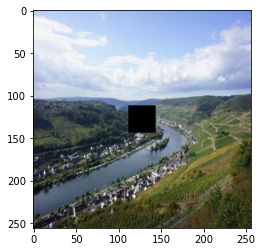

In [5]:
plt.imshow(masked_images[3].permute(1,2,0))

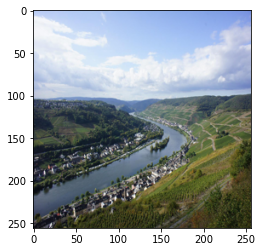

In [6]:
plt.imshow(images[3].permute(1,2,0))

In [7]:
generator_paths = [l for l in os.listdir() if l.find("generator") == 0]

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.encoder2 = nn.Conv2d(64, 128, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.encoder3 = nn.Conv2d(128, 256, 4, 2, 1, bias=True)
        self.bn3 = nn.BatchNorm2d(256)
        self.encoder4 = nn.Conv2d(256, 3, 3, 1, 1, bias=True)


    def forward(self, input):        
        encoded = F.relu(self.bn1(self.encoder1(input)))
        encoded = F.relu(self.bn2(self.encoder2(encoded)))
        encoded = F.relu(self.bn3(self.encoder3(encoded)))
        encoded = F.sigmoid(self.encoder4(encoded))
        return encoded


In [9]:
class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv_query = nn.Conv2d(in_channels,in_channels,(1,1))
        self.conv_key = nn.Conv2d(in_channels,in_channels,(1,1))
        self.conv_value = nn.Conv2d(in_channels,in_channels,(1,1))

    def forward(self, x):
        N, C, H, W = x.shape
        
        q = self.conv_query(x).reshape(N,C,H*W)
        k = self.conv_key(x).reshape(N,C,H*W)
        v = self.conv_value(x).reshape(N,C,H*W)
        attention_weights = torch.softmax(torch.matmul(q.transpose(1, 2), k), dim=-1)
        attention = torch.matmul(v, attention_weights.transpose(1, 2))
        attention = attention.reshape(N, C, H, W)
        return x + attention

In [10]:
class GeneratorWithAttention(nn.Module):
    def __init__(self):
        super(GeneratorWithAttention, self).__init__()
        self.encoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.encoder2 = nn.Conv2d(64, 128, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.encoder3 = nn.Conv2d(128, 256, 4, 2, 1, bias=True)
        self.attn = Attention(256)
        self.bn3 = nn.BatchNorm2d(256)
        self.encoder4 = nn.Conv2d(256, 3, 3, 1, 1, bias=True)


    def forward(self, input):        
        encoded = F.relu(self.bn1(self.encoder1(input)))
        encoded = F.relu(self.bn2(self.encoder2(encoded)))
        encoded = F.relu(self.bn3(self.attn(self.encoder3(encoded))))
        encoded = F.sigmoid(self.encoder4(encoded))
        return encoded


In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.decoder1 = nn.Conv2d(3, 64, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.decoder2 = nn.Conv2d(64, 128, 3, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.decoder3 = nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.decoder4 = nn.Conv2d(256, 1, 3, 2, 0, bias=False)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input):
        decoded = F.relu(self.bn1(self.decoder1(input)))
        decoded = F.relu(self.bn2(self.decoder2(decoded)))
        decoded = F.relu(self.bn3(self.decoder3(decoded)))
        decoded = self.sigmoid(self.decoder4(decoded))
        
        return decoded


In [23]:
discriminator= Discriminator().to(device)

In [11]:
def load_generator(path):
    try:
        generator = Generator()
        generator.load_state_dict(torch.load(path))
        print("Generator Loaded")
    except:
        generator = GeneratorWithAttention()
        generator.load_state_dict(torch.load(path))
        print("Generator with Attention Loaded")
    
    return generator

In [12]:
USE_GPU = True
num_class = 12
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [40]:
reconstruction_loss = nn.MSELoss()
def get_reconstruction_loss(generator,dataloader):
    glosses = []
    for batch_idx, (real_images, masked_images) in enumerate(dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        
        glosses.append(g_loss.item())
    return np.mean(glosses),np.std(glosses)

def get_reconstruction_losses(generator):
    losses = {}
    for name,dataloader in zip(["train","test","val"],[train_dataloader,test_dataloader,val_dataloader]):
        losses[name] = get_reconstruction_loss(generator,dataloader)
    return losses

In [42]:
generator_losses = {}
for generator_path in generator_paths:
    generator = load_generator(generator_path)
    generator = generator.to(device)
    generator_losses[generator_path] = get_reconstruction_losses(generator)
    

Generator with Attention Loaded
Generator with Attention Loaded
Generator Loaded
Generator Loaded


In [52]:
losses = pd.DataFrame(generator_losses).T.reset_index()

In [53]:
losses['train_loss_mean'] = losses['train'].apply(lambda x : x[0])
losses['train_loss_std'] = losses['train'].apply(lambda x : x[1])

losses['val_loss_mean'] = losses['val'].apply(lambda x : x[0])
losses['val_loss_std'] = losses['val'].apply(lambda x : x[1])

losses['test_loss_mean'] = losses['test'].apply(lambda x : x[0])
losses['test_loss_std'] = losses['test'].apply(lambda x : x[1])



In [56]:
losses = losses.sort_values("test_loss_mean")

In [57]:
losses

index  \
1               generator_weights_with_attention.pth   
0  generator_weights_with_gan_reconstruction_loss...   
4                              generator_weights.pth   
3  generator_weights_with_gan_reconstruction_loss...   
2                     generator_weights_with_gan.pth   

                                          train  \
1  (0.02279580582161339, 0.0034854190546717485)   
0   (0.03802922468784512, 0.006931442182439847)   
4  (0.054081459472678145, 0.006191890486195225)   
3   (0.08818852852041624, 0.009522575135476852)   
2   (0.10782654081680337, 0.010384066359513151)   

                                           test  \
1  (0.024672761416205995, 0.004371172857227462)   
0   (0.03712796290906576, 0.006018295659743997)   
4    (0.0560186760356793, 0.006175764579091063)   
3   (0.08355718908401635, 0.004475326023671625)   
2    (0.10882907131543526, 0.01674216244972421)   

                                            val  train_loss_mean  \
1  (0.027903414116455957, 0.007150990956588432)         0.022796   
0  (0.043369924649596214, 0.008118489715052697)         0.038029   
4   (0.05567474319384648, 0.008316943803641463)         0.054081   
3   (0.09377404302358627, 0.012934041282675005)         0.088189   
2   (0.11207371319715793, 0.024395932443428157)         0.107827   

   train_loss_std  val_loss_mean  val_loss_std  test_loss_mean  test_loss_std  
1        0.003485       0.027903      0.007151        0.024673       0.004371  
0        0.006931       0.043370      0.008118        0.037128       0.006018  
4        0.006192       0.055675      0.008317        0.056019       0.006176  
3        0.009523       0.093774      0.012934        0.083557       0.004475  
2        0.010384       0.112074      0.024396        0.108829       0.016742

In [62]:
train_losses_pkls = [l for l in os.listdir() if l.find("train") == 0]
val_losses_pkls = [l for l in os.listdir() if l.find("val") == 0]

In [114]:
val_losses_pkls

['val_with_attention.pickle',
 'val_with_gan_reconstruction_loss.pickle',
 'val_with_gan.pickle',
 'val.pickle',
 'val_with_gan_reconstruction_loss_attention.pickle']

In [115]:
val_name_dict = {}
val_name_dict["val_with_attention.pickle"] = "cnn_generator_with_attention"
val_name_dict["val.pickle"] = "cnn_generator"
val_name_dict["val_with_gan_reconstruction_loss.pickle"] = "gan_generator_with_reconstruction_loss"
val_name_dict["val_with_gan_reconstruction_loss_attention.pickle"] = "gan_attention_generator_with_reconstruction_loss"
val_name_dict["val_with_gan.pickle"] = "gan_generator"


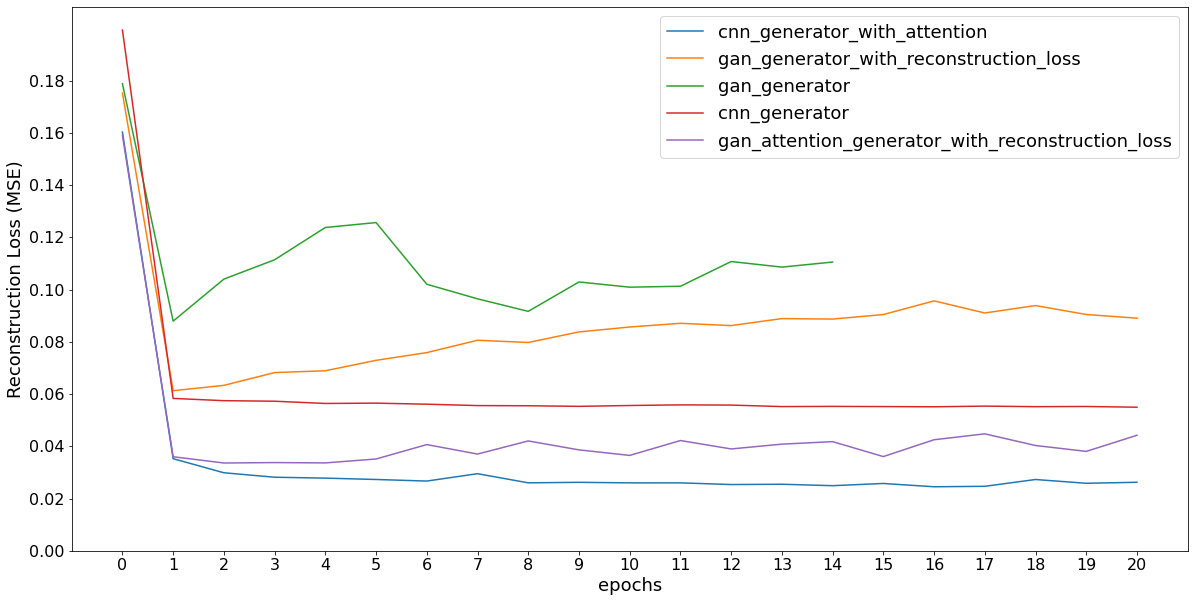

In [125]:
plt.figure(figsize = (20,10))
for val_losses_pkl in val_losses_pkls:
    val_losses = pd.read_pickle(val_losses_pkl)
    plt.plot(list(val_losses.values()),label = val_name_dict[val_losses_pkl],)

plt.legend(fontsize = 18)
plt.xlabel("epochs",fontsize = 18)
plt.ylabel("Reconstruction Loss (MSE)",fontsize = 18)
plt.xticks(range(21),fontsize = 16)
plt.yticks(np.arange(0,0.20,0.02),fontsize = 16)
plt.show()

In [13]:
for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
        break
masked_images = masked_images.to(device)
    
created_images = {}
created_images["masked"] = masked_images
for generator_path in [
 'generator_weights_with_attention.pth',
    'generator_weights_with_gan_reconstruction_loss_attention.pth',
    'generator_weights.pth',
 'generator_weights_with_gan_reconstruction_loss.pth',
 'generator_weights_with_gan.pth',
 ]:
    for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
        break
    
    masked_images = masked_images.to(device)

    generator = load_generator(generator_path)
    generator = generator.to(device)
    predict = generator(masked_images)
    masked_images[:,:,128-p//2:128 + p//2,128-p//2 : 128 + p//2] = predict
    created_images[generator_path] = masked_images

Generator with Attention Loaded
Generator with Attention Loaded
Generator Loaded
Generator Loaded
Generator Loaded


/tmp/ipykernel_21856/3821215418.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(24,4))


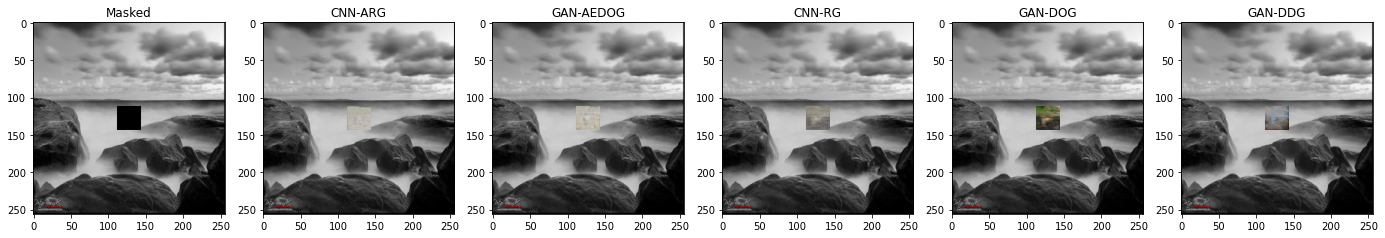

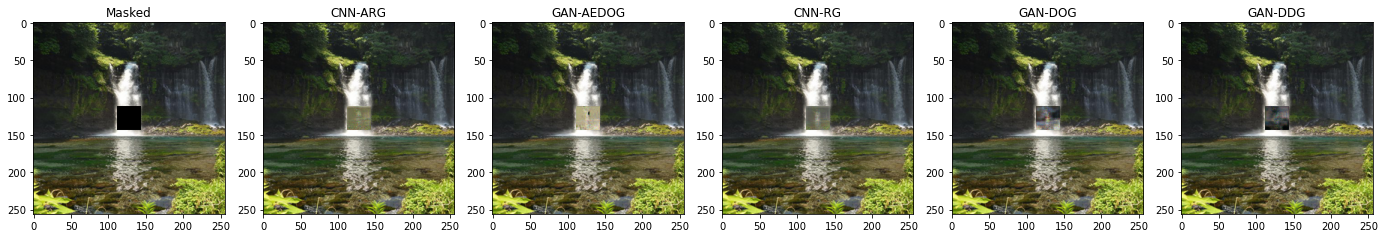

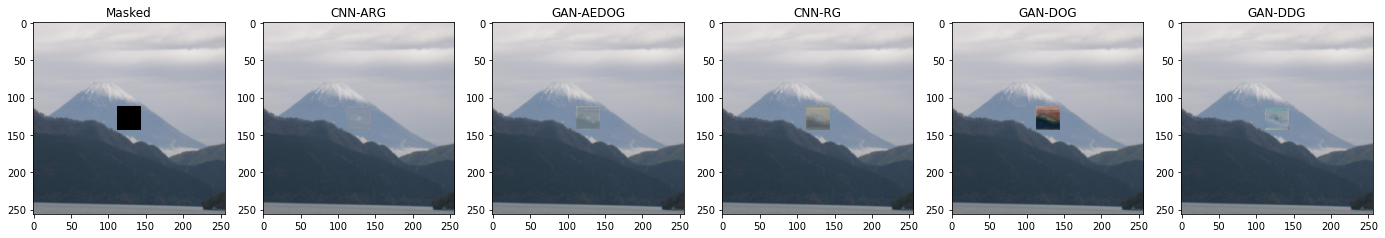

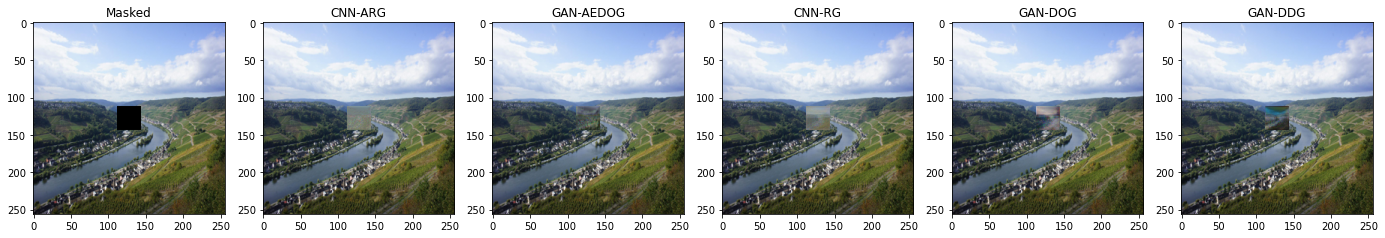

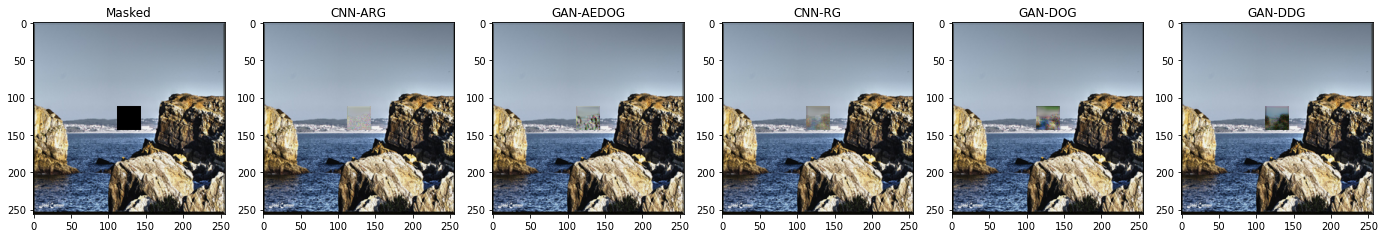

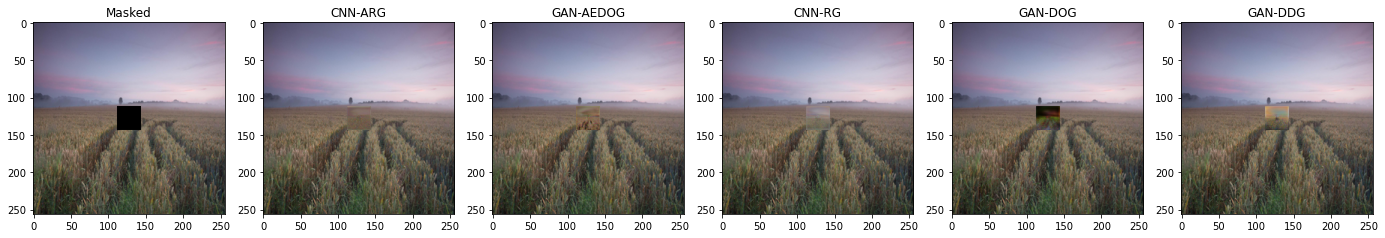

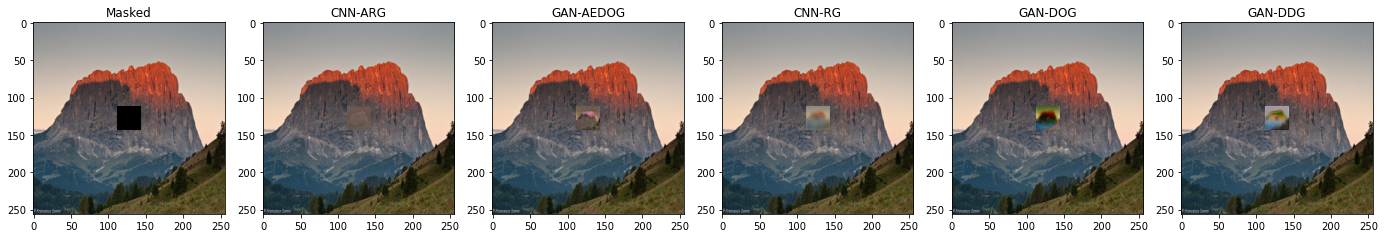

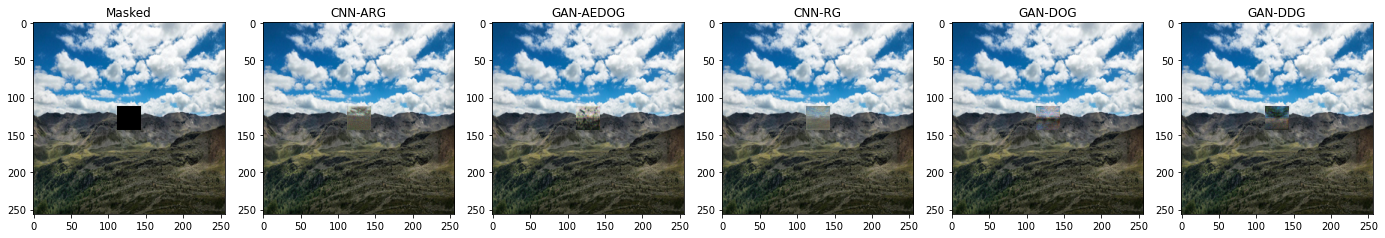

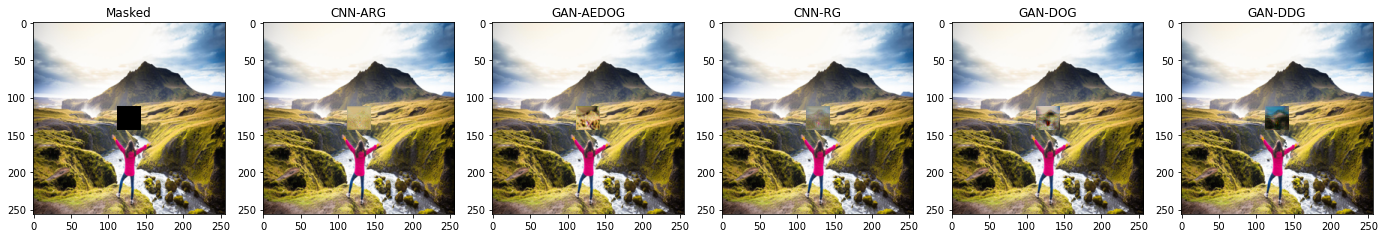

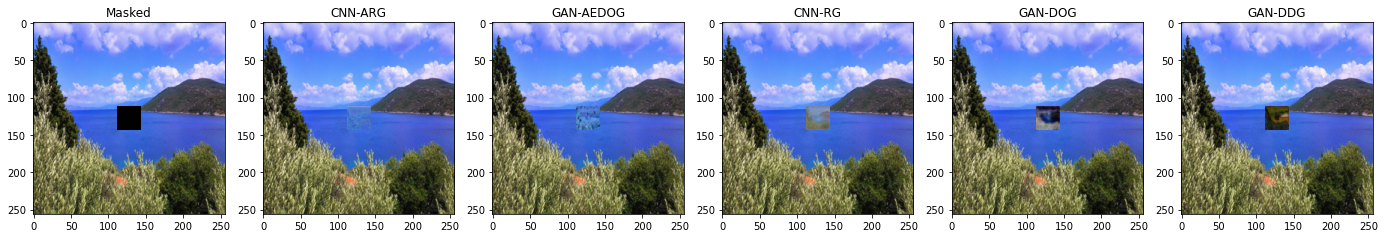

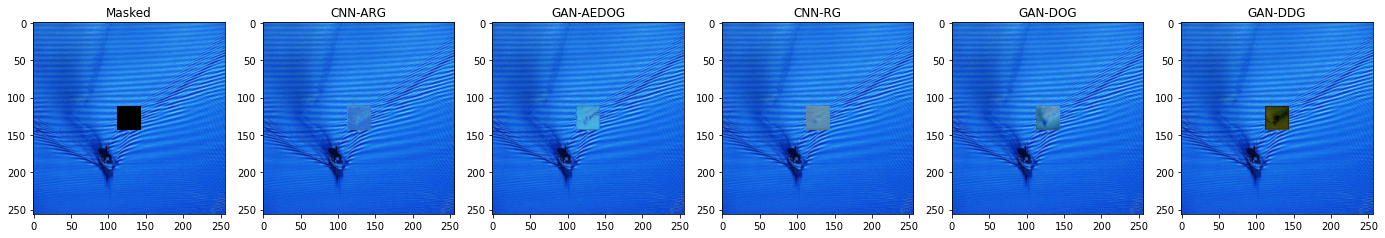

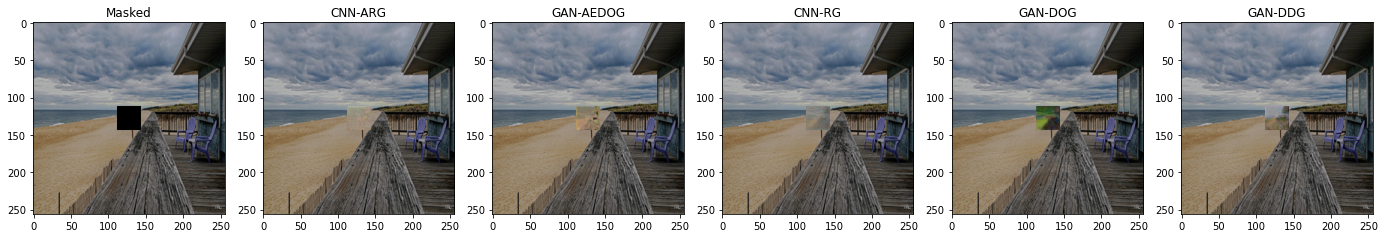

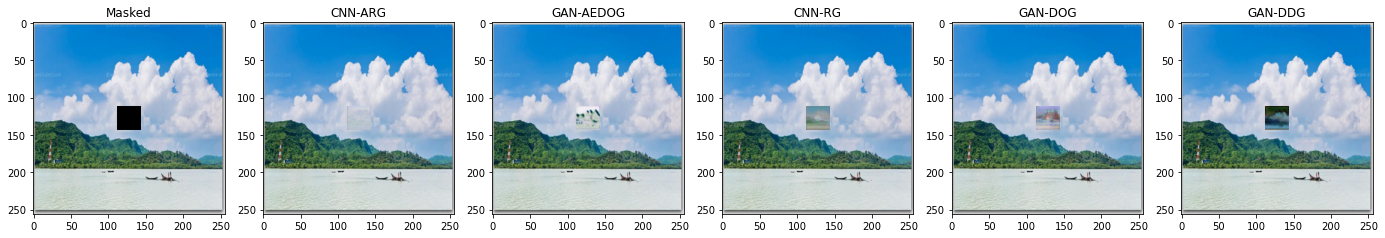

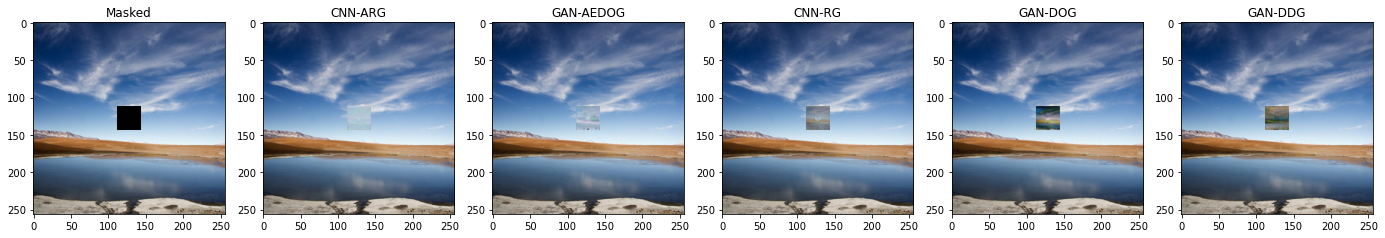

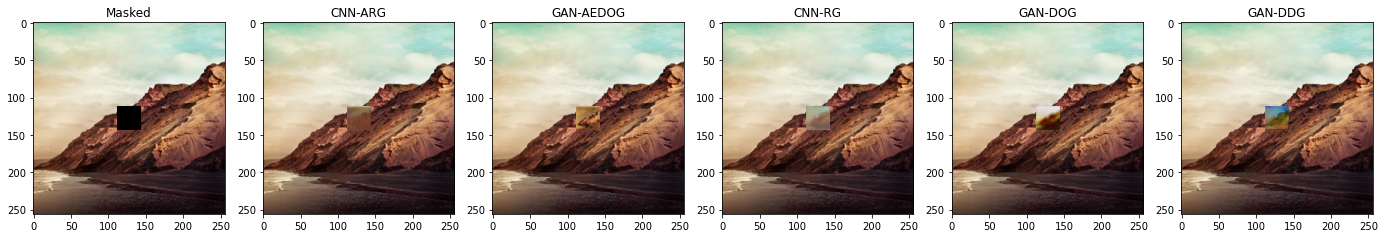

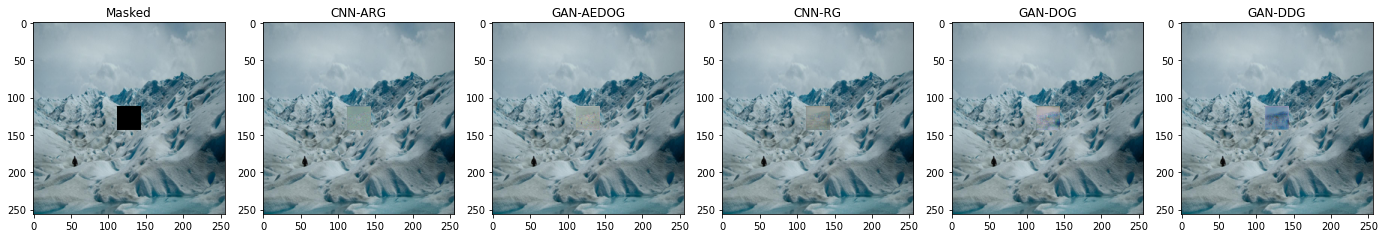

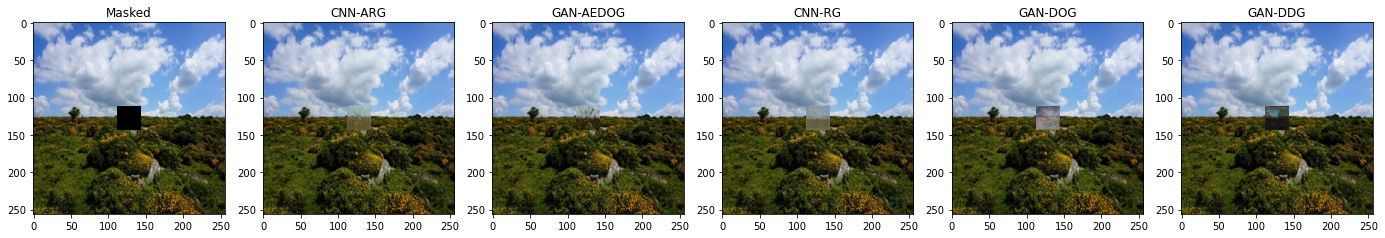

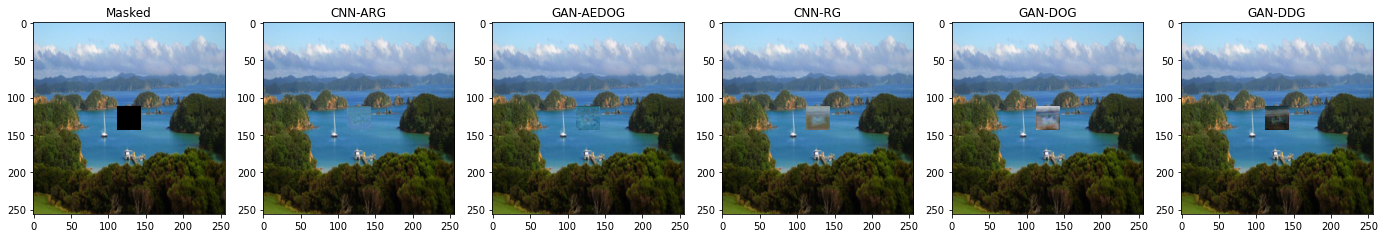

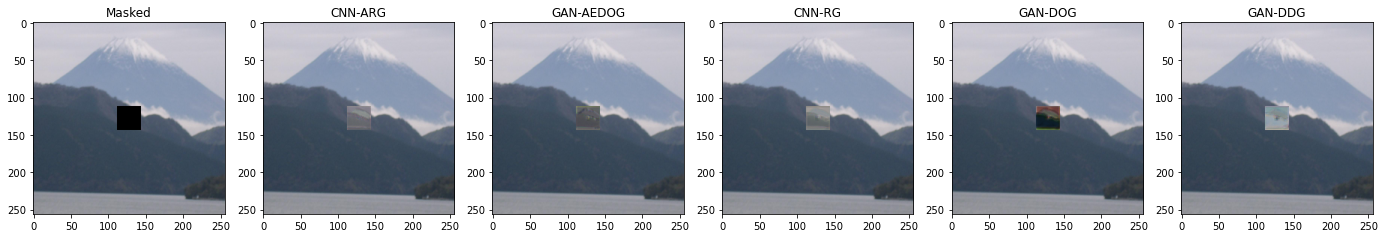

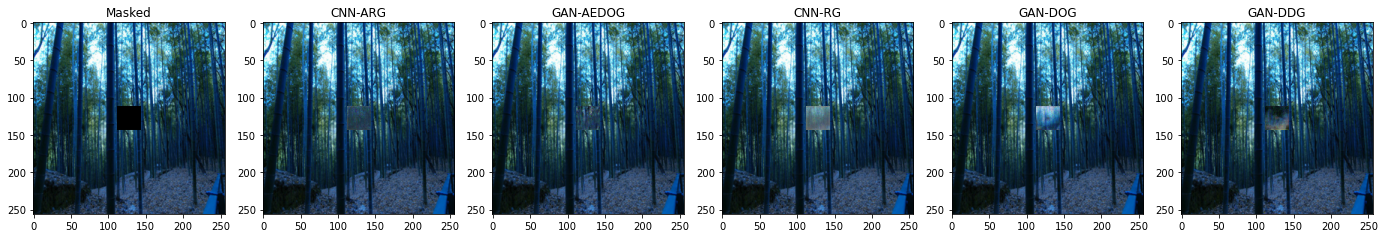

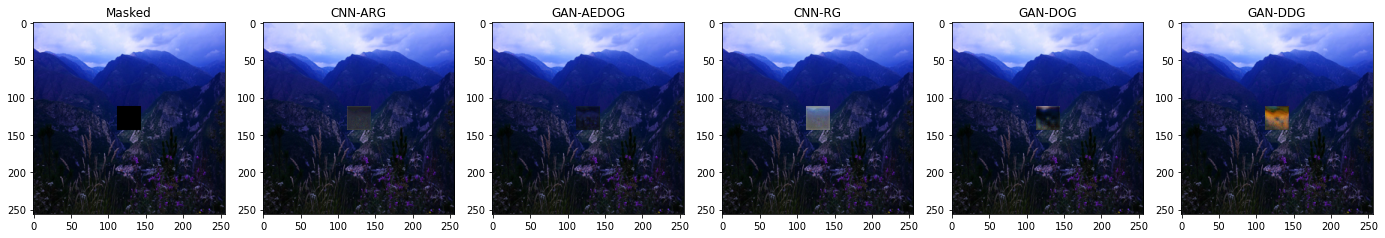

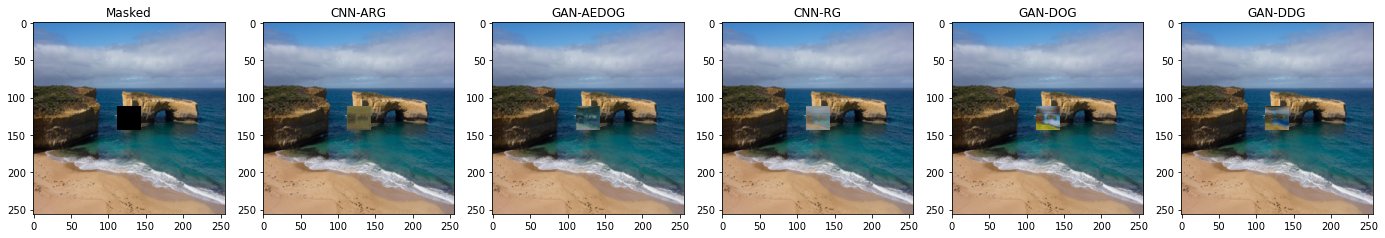

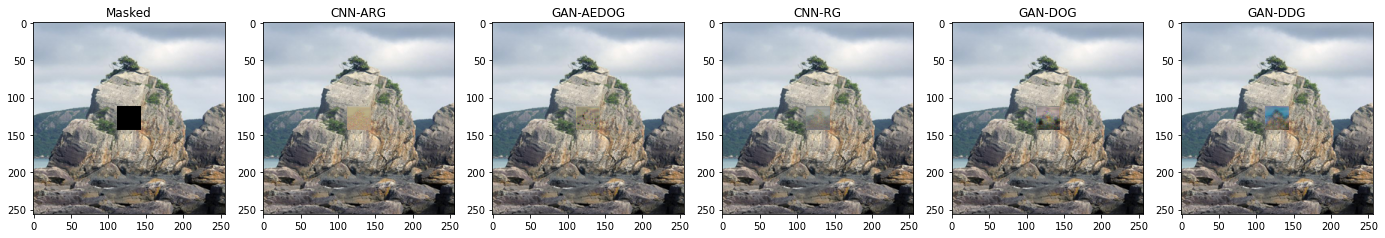

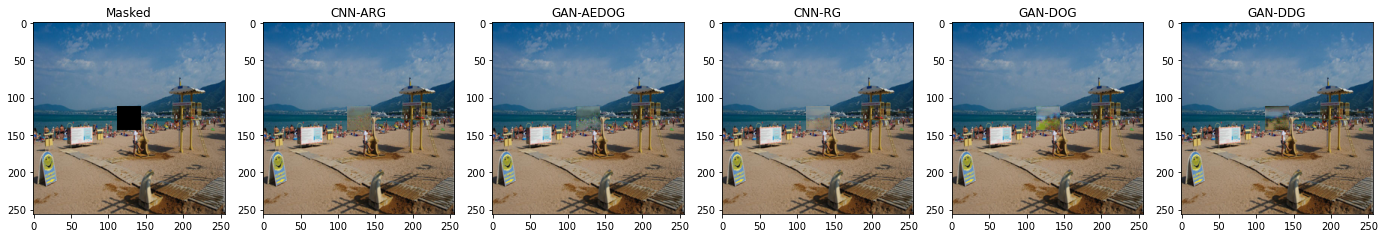

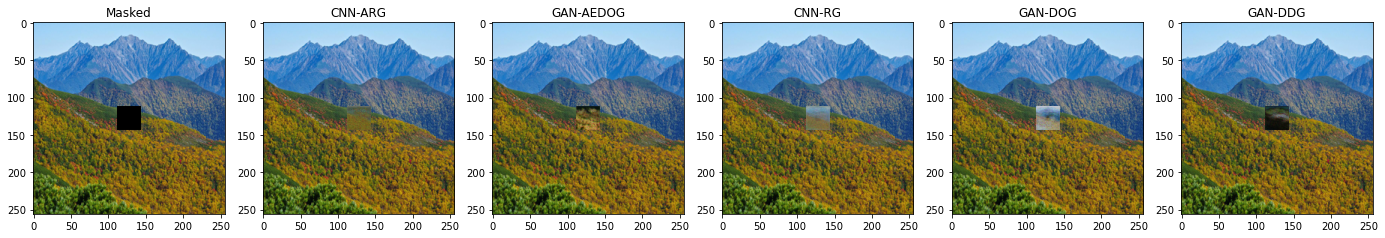

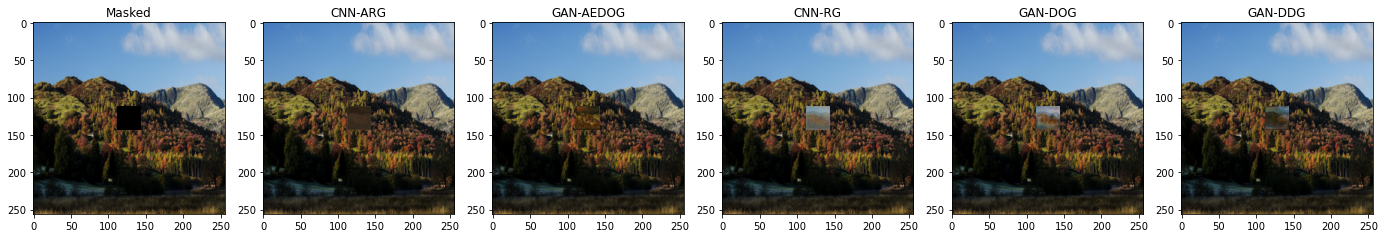

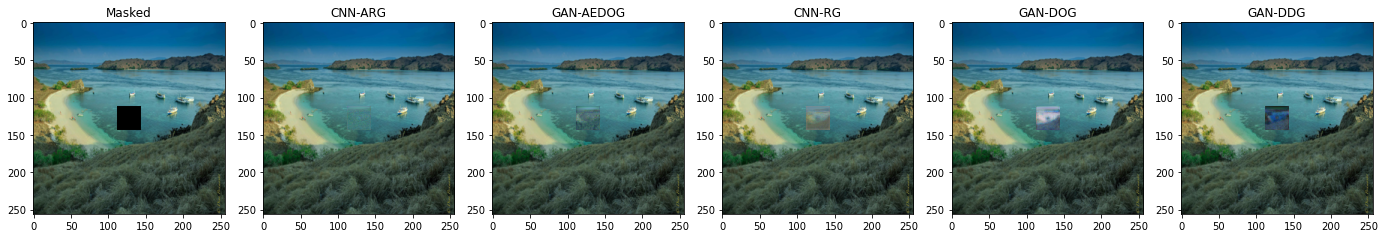

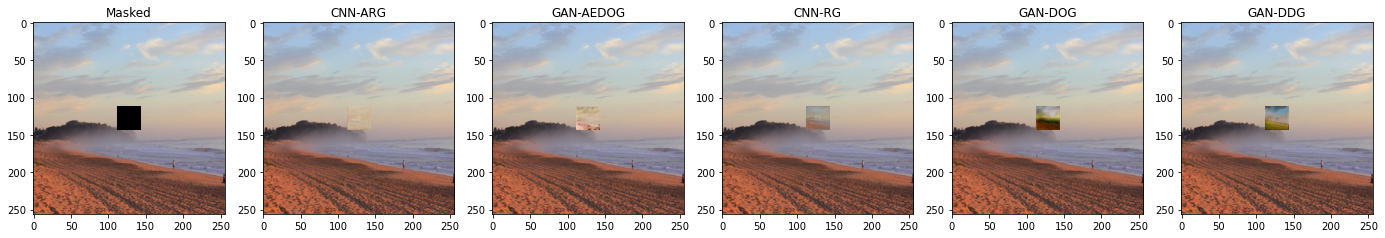

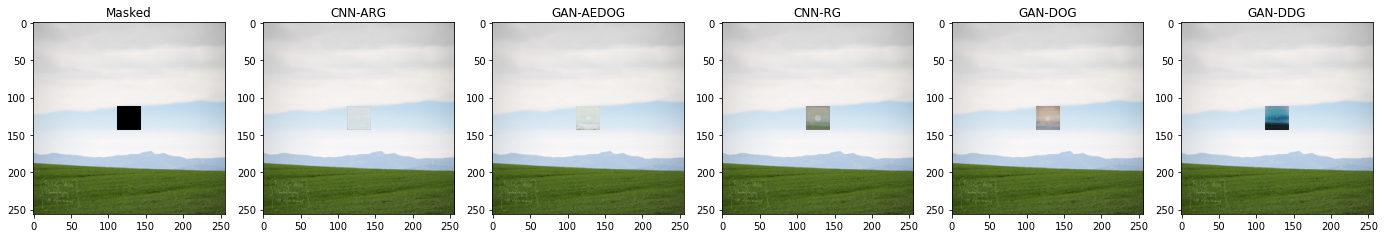

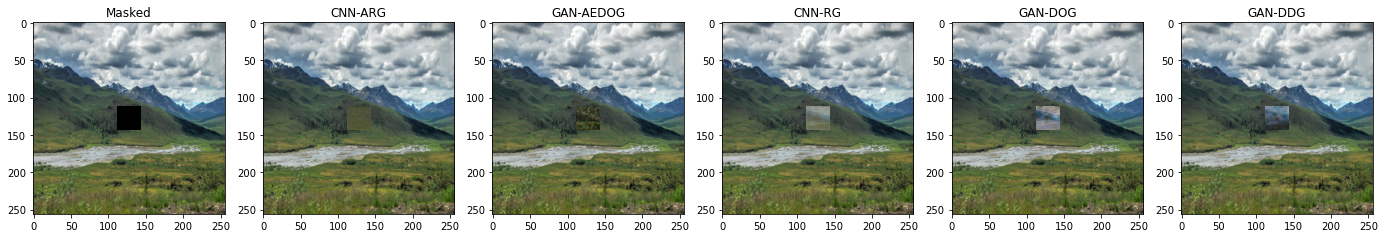

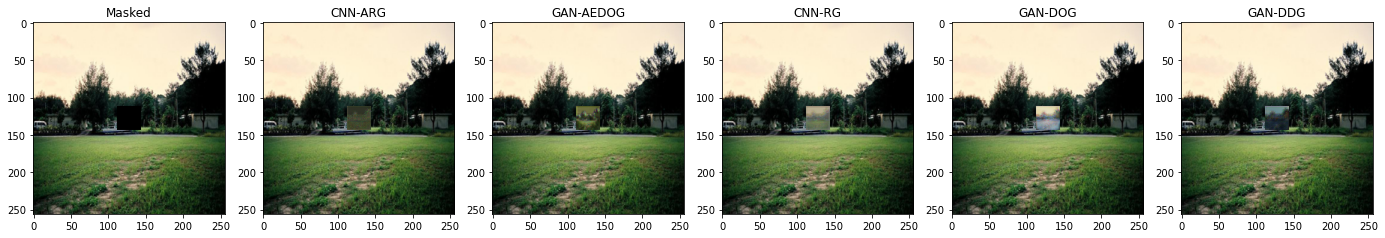

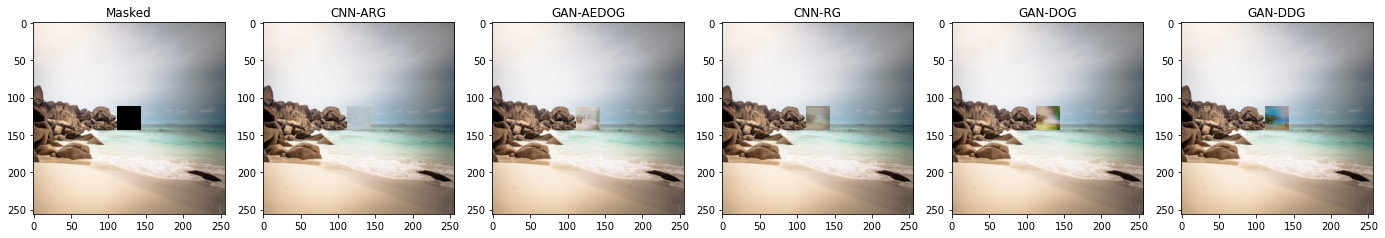

In [15]:
titles = ["Masked","CNN-ARG","GAN-AEDOG","CNN-RG","GAN-DOG","GAN-DDG"]
for i in range(32):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(24,4))
    j = 0
    for key,value in created_images.items():
        axs[j].imshow(value[i].permute(1,2,0).cpu().detach().numpy())
        axs[j].set_title(titles[j])
        j = j + 1
    fig.show()